In [1]:
using DrWatson

@quickactivate "GRNEvoContingency"

projectname()

"GRNEvoContingency"

In [2]:
include(srcdir("TissueModel_ND.jl"))

include(srcdir("Evolution.jl"))
include(srcdir("FitnessFunctions.jl"))

include(srcdir("NetworkTopologies.jl"))
include(srcdir("Utility.jl"))

# using Plots
using CairoMakie
using Random
using Printf
using DataFrames
using JLD
using StatsPlots
using LinearAlgebra
using NearestNeighbors
using DataInterpolations
using Clustering
using GraphMakie
using Graphs
using Distances

example_networks = load(datadir("exp_pro/80-40-80_networks/examples.jld"))

df = collect_results(datadir("sims/repeated_evolution_different_topologies"));

df_current = filter(:n_traj=>x->x==2500,df);

evolutionary_runs = Dict{String,Any}("classical"=>df_current[:,"raw_data"][1],"feed_forward"=>df_current[:,"raw_data"][2],"mutual_inh"=>df_current[:,"raw_data"][3],"overlap_dom"=>df_current[:,"raw_data"][4]);

┌ Info: Scanning folder /Users/boothh/Documents/GRNEvoContingency/data/sims/repeated_evolution_different_topologies for result files.
└ @ DrWatson /Users/boothh/.julia/packages/DrWatson/UkasH/src/result_collection.jl:115
┌ Info: Added 13 entries.
└ @ DrWatson /Users/boothh/.julia/packages/DrWatson/UkasH/src/result_collection.jl:191


In [3]:
topology = "overlap_dom"

start_network = example_networks[topology]
run_data = evolutionary_runs[topology];

evo_traces = map(x->x[2],run_data);

geno_traj = map(et->reduce(hcat,unique(map(x->vec(x),et.traversed_topologies))),evo_traces);

In [6]:
end_networks = map(et->et.traversed_topologies[end],evo_traces);

In [12]:
grn_parameters = DefaultGRNParameters()

GRNParameters([0.05, 0.05, 0.05], [0.01 0.01 … 0.01 0.01; 0.01 0.01 … 0.01 0.01; 0.01 0.01 … 0.01 0.01])

In [15]:
function get_full_pheno(start_network)
    p = (start_network,grn_parameters.degradation)
        
    grn = ODEProblem(gene_regulation_1d!,grn_parameters.g0,(0,Inf),p)

    development = DefaultGRNSolver()

    founder = Individual(grn,development)

    return founder.phenotype.u[end]
end

get_full_pheno (generic function with 1 method)

In [20]:
all_pheno = map(x->vec(get_full_pheno(x)),end_networks)

2500-element Vector{Vector{Float64}}:
 [13.747088170094145, 19.992162535188484, 0.03379502251413147, 13.383244375609616, 19.991674589699944, 0.036672439634724, 13.008263204501606, 19.99112245734257, 0.04003921553236922, 12.62356293125589  …  0.40328331296855086, 0.5551161245735969, 1.0422096469913222, 0.4034273814929723, 0.5537873527275694, 1.0398022822203745, 0.4035700676222764, 0.5524797089454259, 1.0374408849367345, 0.4037113691366512]
 [18.563292177125607, 19.977190367631476, 0.09674679873193592, 18.476908715179913, 19.97693135932837, 0.09991358247579017, 18.384421482574336, 19.976649134745927, 0.10347853946393704, 18.28536940955896  …  0.43973614432475383, 0.5974192291010749, 0.6736125306083485, 0.44018035813714657, 0.5954224472313407, 0.6727068445605922, 0.4406179941694133, 0.5934601069539691, 0.6718184969186236, 0.4410491594855192]
 [10.731217250514863, 19.986194853741914, 0.07559287720490748, 10.41355081588169, 19.9851920688376, 0.08412484831705092, 10.098659352252518, 19.98408

In [22]:
X = Float32.(reduce(hcat,all_pheno));

In [23]:
X

600×2500 Matrix{Float32}:
 13.7471     18.5633     10.7312     …  17.5171      9.68403    16.5886
 19.9922     19.9772     19.9862        19.9894     19.9864     19.9743
  0.033795    0.0967468   0.0755929      0.0355127   0.0380296   0.0722447
 13.3832     18.4769     10.4136        17.3565      9.29412    16.3659
 19.9917     19.9769     19.9852        19.9892     19.985      19.9734
  0.0366724   0.0999136   0.0841248  …   0.0368339   0.0432318   0.0776719
 13.0083     18.3844     10.0987        17.1848      8.91209    16.1291
 19.9911     19.9766     19.9841        19.9889     19.9835     19.9725
  0.0400392   0.103479    0.0940828      0.0383303   0.0494337   0.084134
 12.6236     18.2854      9.78708       17.0013      8.53934    15.8779
  ⋮                                  ⋱                          
  0.555116    0.597419    0.550944       0.578657    0.545213    0.5747
  1.04221     0.673613    1.03468        0.803671    1.1449      0.774935
  0.403427    0.44018     0.403878 

In [41]:
using Flux

device = cpu # where will the calculations be performed?
# L1 = 300 # layer dimensions
L2 = 100
L3 = 2
η = 0.01 # learning rate for ADAM optimization algorithm
batch_size = 100

100

In [42]:
using Flux.Data, MLDatasets

function get_data(X,batch_size)
    # xtrain, _ = MLDatasets.MNIST.traindata(Float32)
    # d = prod(size(xtrain)[1:2]) # input dimension
    # xtrain1d = reshape(xtrain, d, :) # reshape input as a 784-dimesnonal vector (28*28)
    dl = Flux.DataLoader(X, batchsize=batch_size, shuffle=true)
    dl, size(X,1)
end

dl, d = get_data(X,batch_size)

(DataLoader(::Matrix{Float32}, shuffle=true, batchsize=100), 600)

In [43]:
function train!(model_loss, model_params, opt, loader, epochs = 10)
    train_steps = 0
    "Start training for total $(epochs) epochs" |> println
    for epoch = 1:epochs
        # print("Epoch $(epoch): ")
        ℒ = 0
        for x in loader
            loss, back = Flux.pullback(model_params) do
                model_loss(x |> device)
            end
            grad = back(1f0)
            Flux.Optimise.update!(opt, model_params, grad)
            train_steps += 1
            ℒ += loss
        end

        if epoch == epochs
            println("ℒ = $ℒ")
        end
    end
    "Total train steps: $train_steps" |> println
end

train! (generic function with 2 methods)

In [54]:
# enc1 = Dense(d, L1, leakyrelu)
enc1 = Dense(d, L2, leakyrelu)
enc2 = Dense(L2, L3, leakyrelu)
dec1 = Dense(L3, L2, leakyrelu)
dec2 = Dense(L2, d, leakyrelu)
# dec3 = Dense(L1, d, leakyrelu)


m = Chain(enc1,enc2,dec1,dec2) |> device

Chain(
  Dense(600 => 100, leakyrelu),         # 60_100 parameters
  Dense(100 => 2, leakyrelu),           # 202 parameters
  Dense(2 => 100, leakyrelu),           # 300 parameters
  Dense(100 => 600, leakyrelu),         # 60_600 parameters
)                   # Total: 8 arrays, 121_202 parameters, 473.945 KiB.

In [45]:
loss(x) = Flux.Losses.mse(m(x), x)

data_sample = dl |> first |> device;

loss(data_sample)

56.46519f0

In [55]:
opt = ADAM(0.001)
ps = Flux.params(m) # parameters

train!(loss, ps, opt, dl, 100)

Start training for total 100 epochs


ℒ = 42.105934
Total train steps: 2500


In [117]:
train!(loss, ps, opt, dl, 500)

Start training for total 500 epochs


ℒ = 17.080938
Total train steps: 12500


In [118]:
total_enc(x) = enc2(enc1(x))
total_dec(x) = dec2(dec1(x))

total_dec (generic function with 1 method)

In [119]:
example_pheno = X[:,2]
example_pheno_m = reshape(X[:,2],(3,200))

3×200 Matrix{Float32}:
 18.5633     18.4769     18.3844    …  0.597419  0.595422  0.59346
 19.9772     19.9769     19.9766       0.673613  0.672707  0.671818
  0.0967468   0.0999136   0.103479     0.44018   0.440618  0.441049

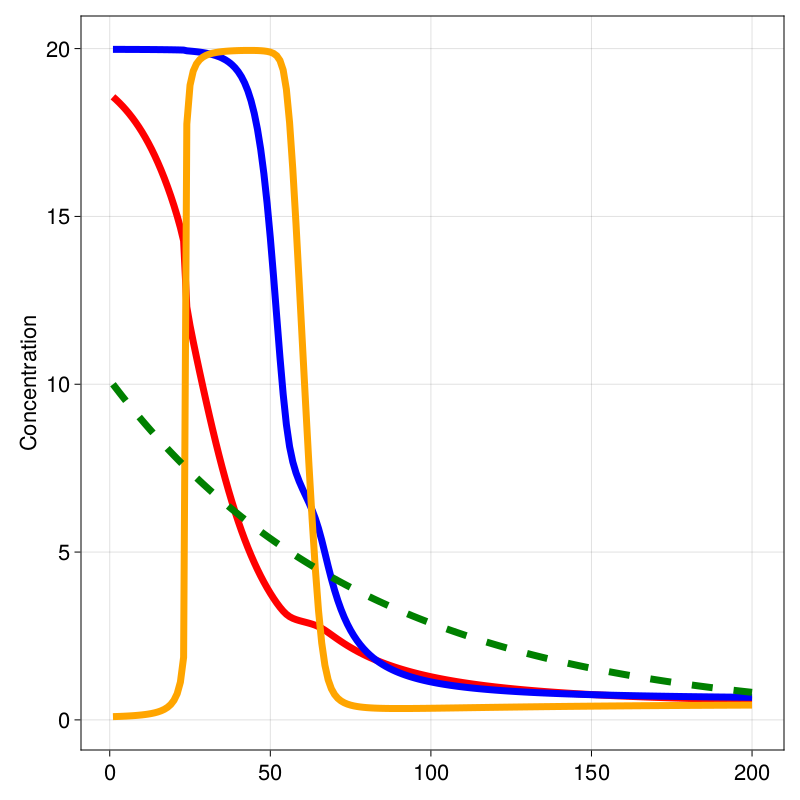

In [120]:
fig = CairoMakie.Figure(resolution = (800, 800),fontsize = 22.)

color_scheme = palette(:tab10)

weight_indices = Tuple.(findall(ones(3,4) .> 0));

vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

line_colors = [:red,:blue,:orange,:green]

ax2  = Axis(fig[1,1], backgroundcolor = "white", ylabel = "Concentration")

for i in 1:3
    lines!(ax2,example_pheno_m[i,:],label = "Gene " * vertex_names[i], color = line_colors[i],linewidth = 7.)
end

lines!(ax2,map(x->morph(x),tissue),label = "Morphogen, M",linewidth = 7.,linestyle = "--",color = :green)

fig

In [121]:
pos_p = total_enc(example_pheno)

2-element Vector{Float32}:
 34.4143
 56.543537

In [122]:
reconstructed_pheno = reshape(total_dec(pos_p),(3,200))

3×200 Matrix{Float32}:
 17.7429    17.6618    17.5108    17.3789  …  0.587077  0.576931  0.579889
 19.9809    19.992     20.0065    19.9907     0.637805  0.632501  0.630413
  0.262991   0.280655   0.285931   0.3121     0.506875  0.474188  0.498873

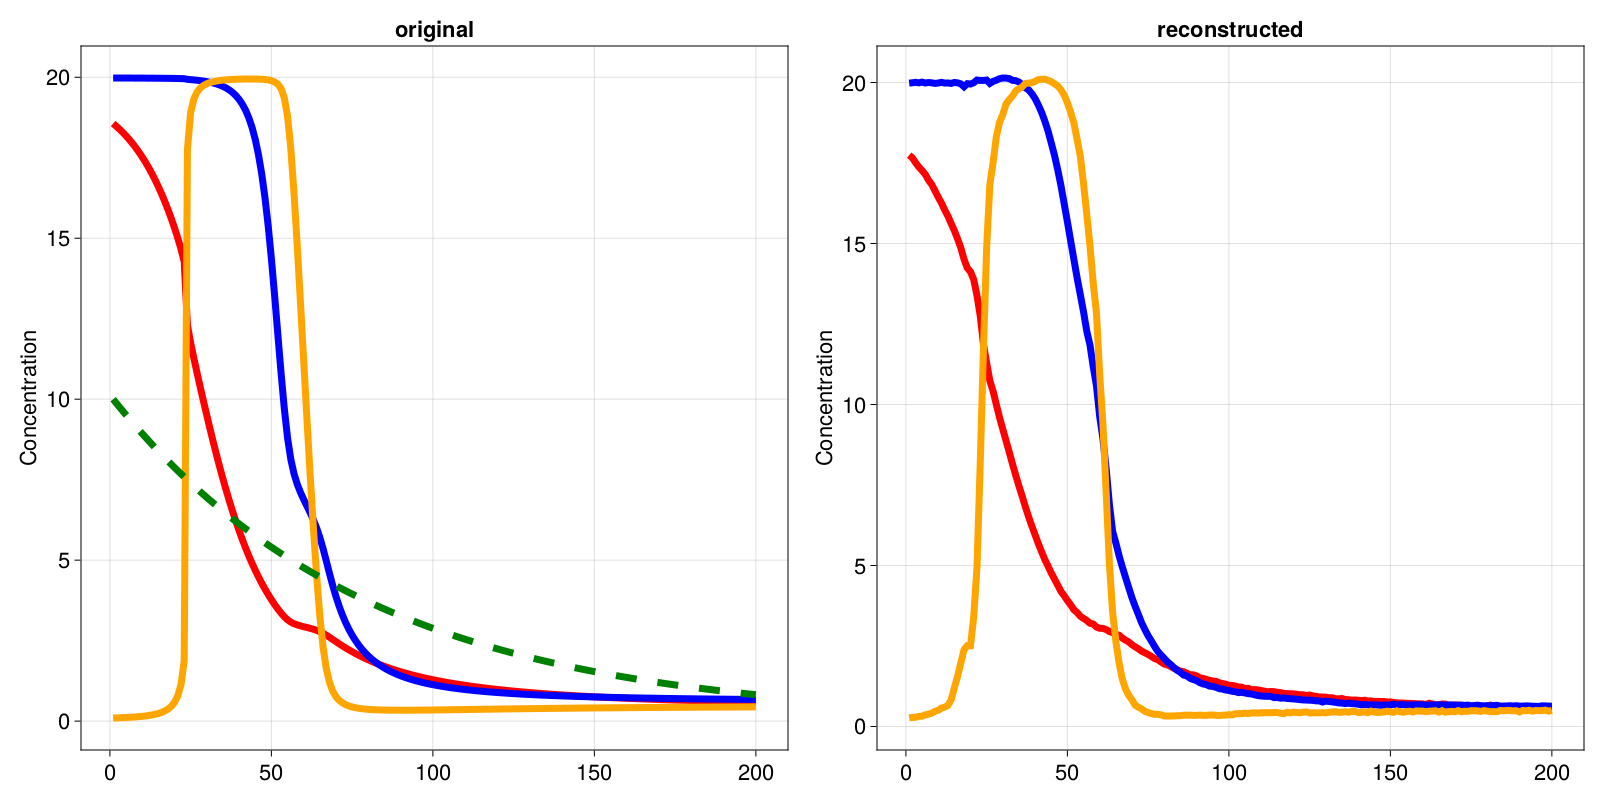

In [123]:
fig = CairoMakie.Figure(resolution = (1600, 800),fontsize = 22.)

color_scheme = palette(:tab10)

weight_indices = Tuple.(findall(ones(3,4) .> 0));

vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

line_colors = [:red,:blue,:orange,:green]

ax2  = Axis(fig[1,2], backgroundcolor = "white", title = "reconstructed",ylabel = "Concentration")

for i in 1:3
    lines!(ax2,reconstructed_pheno[i,:],label = "Gene " * vertex_names[i], color = line_colors[i],linewidth = 7.)
end

ax1  = Axis(fig[1,1], backgroundcolor = "white", title = "original",ylabel = "Concentration")

for i in 1:3
    lines!(ax1,example_pheno_m[i,:],label = "Gene " * vertex_names[i], color = line_colors[i],linewidth = 7.)
end


lines!(ax1,map(x->morph(x),tissue),label = "Morphogen, M",linewidth = 7.,linestyle = "--",color = :green)

fig

In [112]:
using BSON: @save

In [114]:
# @save "pheno_auto_v1.bson" m

In [124]:
end_net_enc = Tuple.(map(x->total_enc(x),all_pheno));

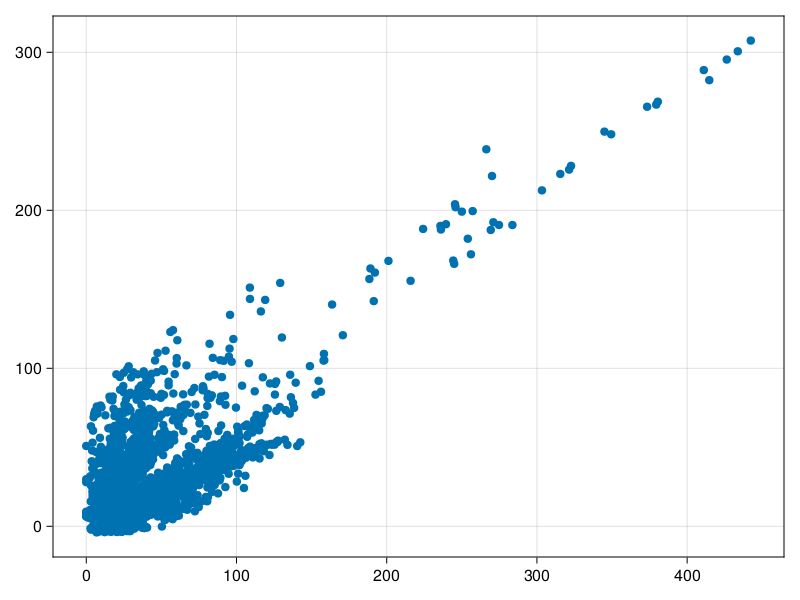

In [125]:
CairoMakie.scatter(end_net_enc)

In [143]:
paths_latent = map(x->mapslices(s->total_enc(s),x,dims = 1),geno_traj);

In [144]:
path_latent_t = map(x->mapslices(s->(s[1],s[2]),x,dims = 1)[1,:],paths_latent);

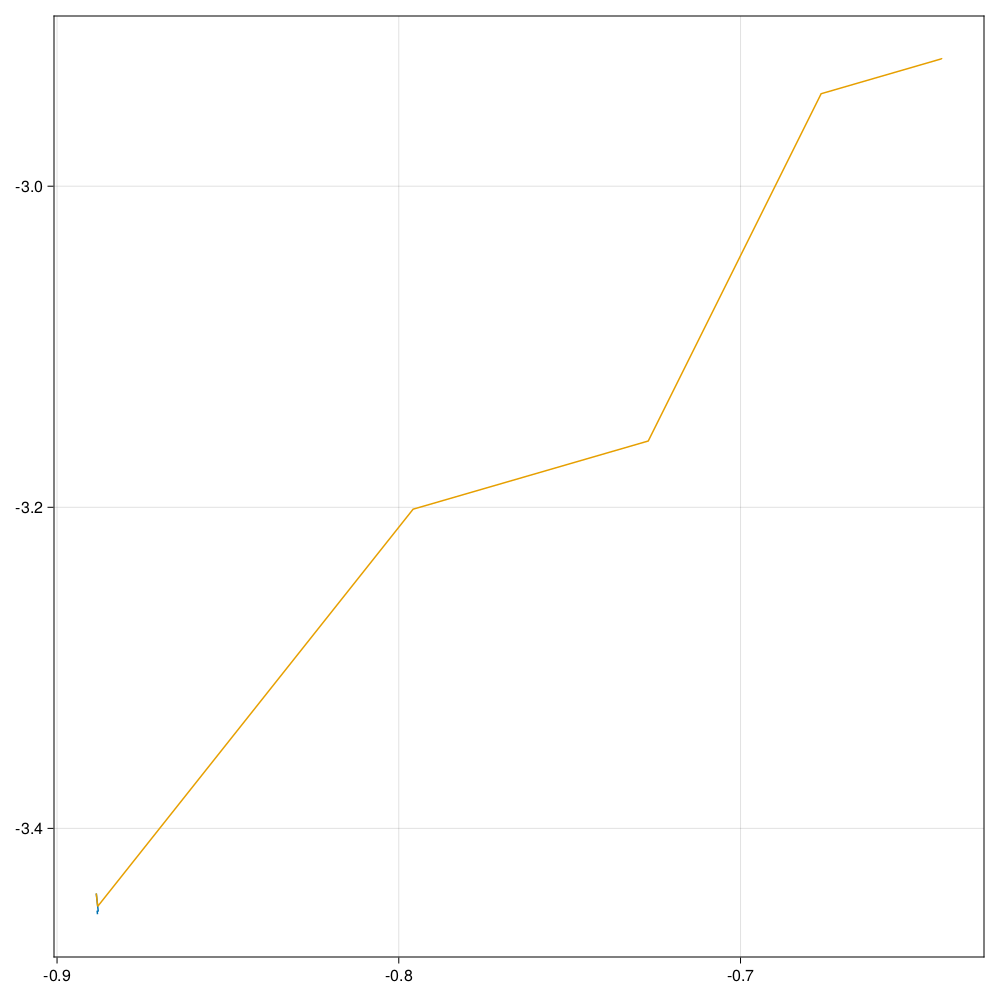

In [153]:
fig = CairoMakie.Figure(resolution = (1000,1000))
ax = Axis(fig[1,1])

CairoMakie.lines!(ax,path_latent_t[1])
# CairoMakie.lines!(ax,path_latent_t[10])
CairoMakie.lines!(ax,path_latent_t[2])

fig

In [150]:
path_latent_t[1]

4-element Vector{Tuple{Float64, Float64}}:
 (-0.8885205564629971, -3.440562884230482)
 (-0.8879550341733763, -3.4514341080846282)
 (-0.88825454899629, -3.4516708526033213)
 (-0.888160500620125, -3.4534787759498773)

In [151]:
path_latent_t[2]

7-element Vector{Tuple{Float64, Float64}}:
 (-0.8885205564629971, -3.440562884230482)
 (-0.8881032419923738, -3.448585059679586)
 (-0.795807585768754, -3.2011740522741157)
 (-0.7270029293054684, -3.1587055249527567)
 (-0.6764046023887188, -2.942377353143608)
 (-0.6411596708482761, -2.9206230066356302)
 (-0.6411233703841123, -2.9208573923911354)